# Prepare the data

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

### Load data & tokenize

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = ['.'] + sorted(list(set("".join(words))))
vocab_size = len(chars)

stoi = {char:i for i, char in enumerate(chars)}
itos = {i: char for char, i  in stoi.items()}

print(len(words))
print(vocab_size)

32033
27


### Create a train/val/tast split

In [3]:
block_size = 6

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP

### Initialize parameters

In [4]:
embed_size = 10

In [5]:
E = torch.randn((vocab_size, embed_size))       # 27 x 10
W1 = torch.randn((embed_size*block_size, 300))  # 60 x 300
b1 = torch.randn(300)                           # 300
W2 = torch.randn((300, vocab_size))             # 300 x 27
b2 = torch.randn(vocab_size)                    #  27
parameters = [E, W1, W2, b1, b2]
for p in parameters:
    p.requires_grad = True

In [6]:
# Number of parameters in the model
params = sum(p.nelement() for p in parameters)
params

26697

# Training

In [7]:
lre = torch.linspace(-3, 0, 1000) 
lrs = 100**lre

In [8]:
lri= []
lossi = []
stepi = []

In [9]:
for _ in range(200000):
    
    ix = torch.randint(1, Xtr.shape[0], (64, ))
    
    emb = E[Xtr[ix]]
    h = torch.tanh(emb.view(-1, embed_size*block_size) @ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if _ < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # lri.append(lre[_])
    stepi.append(_)
    lossi.append(loss.log10().item())
print(loss.item())

2.1738953590393066


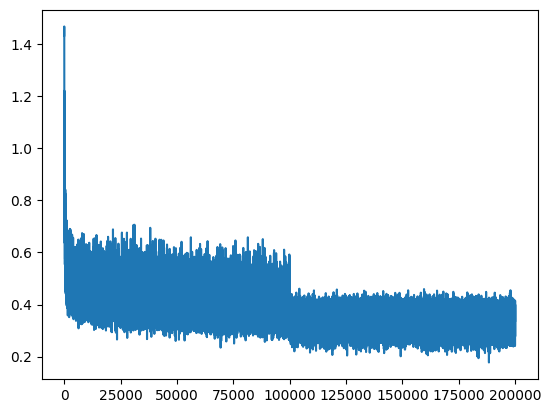

In [10]:
plt.plot(stepi, lossi)

### Evaluating loss

In [11]:
emb = E[Xtr]
h = torch.tanh(emb.view(-1, embed_size*block_size) @ W1 + b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1744, grad_fn=<NllLossBackward0>)

In [12]:
emb = E[Xdev]
h = torch.tanh(emb.view(-1, embed_size*block_size) @ W1 + b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1908, grad_fn=<NllLossBackward0>)

In [13]:
emb = E[Xte]
h = torch.tanh(emb.view(-1, embed_size*block_size) @ W1 + b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2114, grad_fn=<NllLossBackward0>)

# Sampling from the model

In [14]:
for i in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb1 = E[torch.tensor([context])]
        h = torch.tanh(emb1.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        ix = torch.multinomial(p, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix ==0:
            break
        
    print(''.join(itos[i] for i in out ))

revine.
akrevie.
heiton.
brich.
fachwu.
rome.
dovinne.
zan.
zerlaan.
kanyson.
deeille.
tansyn.
coalius.
damonosery.
sashir.
hama.
shiia.
khana.
braxt.
nioter.


## Pretty good))